This notebook will explore the photon occupation of the ground-state of MgH+ in the ultrastrong coupling regime.  This analysis is inspired by Figure 2a in the paper 
["Virtual photons in the ground state of a dissipative system"](https://www.nature.com/articles/s41467-017-01504-5)
 by Simone De Liberato.  The data generated in this notebook corresponds to Figure 4 in McTague and Foley.


In [1]:
from __future__ import print_function

"""
A script to run the cqed_rhf and cqed_cis method on MgH+ potential energy surface in a cc-pVDZ basis set,
reproducing data from Figure 3 by McTague and Foley.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_ciss_prism import *
from matplotlib import pyplot as plt
# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2



  Memory set to   1.863 GiB by Python driver.


We will explore the photon occupation in the ground state under different cavity coupling
and dissipation rates.  In particular, we will consider cavity coupling strengths $g$ relative 
to the photon energy / transition energy as follows:

$$ g = N\frac{\omega}{2}, $$
where $N = 0.5, 1, 1.5, 2$.

We can estimate $g$ as 

$$ g = \sqrt{\frac{\omega}{2}}\lambda \mu $$, 

where we can rearrange for $\lambda$:

$$ \lambda = \frac{f}{\mu \sqrt{\frac{1}{2\omega}}} $$
where $f = 0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,  0.5$.

Additionally, we will consider an imaginary part of the frequency $\gamma$ such 
that 
$$ \gamma = m \omega, $$
where $m = 0.0, 0.5, 1.0, 1.5, 2.0$.

In [3]:
# template for z-matrix
molstr = """
Mg
H 1 2.2
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options
psi4.set_options(options_dict)

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# fix real part of omega
om_r = 4.75 / 27.211

# approximate max value of g
#g_max = np.sqrt(om_r/2) * lam_z * max_tdm

# this is a list of fraction values that is used to compute the value
# of \lambda such that the g/\omega is a fraction with the following magnitudes
f_list = np.array([0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,  0.5])

# this is a list of fraction values that is used to define the \gamma value
# relative to the real part of the frequency \omega
m_list = np.array([0, 0.5, 1.0, 1.5, 2.0])

# photon energy
om_r = 4.75 / 27.211

# define the different values of \lambda
lambda_list = f_list / (max_tdm * np.sqrt(1/(2 * om_r)))
print("lambda list")
print(lambda_list)


# get in terms of g
g_list = np.sqrt(om_r/2) * lambda_list * max_tdm
print("g list")
print(g_list)

# define the different values of \gamma
gamma_list = om_r * m_list
print("gamma list")
print(gamma_list)

relative_strength = np.zeros(len(f_list))
# array to hold the cs-cqed-cis energies
#cqed_cis_energy_array = np.zeros((5, n_lam),dtype=complex)

# array to hold the photon occupations of the ground state
photon_occupation_zo = np.zeros(len(f_list))
photon_occupation_fo = np.zeros(len(f_list))
photon_occupation_so = np.zeros(len(f_list))
photon_occupation = np.zeros(len(f_list))



# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
n_state = 0
l_ctr = 0
mol = psi4.geometry(molstr)
e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
for l in lambda_list:
    lam = np.array([0, 0, l])
    om = om_r 
    cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
    g_c = np.sqrt(om/2) * l * max_tdm
    relative_strength[l_ctr] = np.real( np.sqrt( np.conj(g_c) * g_c ))
    C = cqed_dict['C VECTOR']
    r1_offset = cqed_dict["R1 OFFSET"]
    H_DSE = cqed_dict["H CISS-DSE"]
    H_BLC = cqed_dict["H CISS-BLC"]
    po_l = 0.
    for i in range(r1_offset, len(C[:,0])):
        po_l += np.real(np.conj(C[i,n_state]) * C[i,n_state])
    photon_occupation_zo[l_ctr] = po_l
    
    fo = np.dot(C[:,n_state].T, H_BLC).dot(C[:,n_state])
    photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
    
    so = np.dot(C[:,n_state].T, H_DSE).dot(C[:,n_state])
    photon_occupation_so[l_ctr] = 1 / (2 * om) * so
    
    photon_occupation[l_ctr] = po_l - np.sqrt( 1/ (2 * om )) * fo + 1 / (2 * om) * so
    
    l_ctr += 1

    

 

lambda list
[0.         0.01313037 0.02626074 0.03939112 0.05252149 0.06565186
 0.07878223 0.09191261 0.10504298 0.11817335 0.13130372]
g list
[0.         0.00872809 0.01745618 0.02618426 0.03491235 0.04364044
 0.05236853 0.06109662 0.0698247  0.07855279 0.08728088]
gamma list
[0.         0.08728088 0.17456176 0.26184264 0.34912352]

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.6658775836986592
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8639591041884387   dE = -1.99864E+02   dRMS = 4.60245E-08
SCF Iteration   2: Energy = -199.8639591041913377   dE = -2.89901E-12   dRMS = 1.41194E-08
Total time for SCF iterations: 0.003 seconds 

QED-RHF   energy: -199.86395910 hartree
Psi4  SCF energy: -199.86395910 hartree


/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.6639533628488721
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0010444338789613
SCF Iteration   1: Energy = -199.8632653681675890   dE = -1.99863E+02   dRMS = 2.79123E-05
SCF Iteration   2: Energy = -199.8632667921050086   dE = -1.42394E-06   dRMS = 1.05392E-05
SCF Iteration   3: Energy = -199.8632669617662145   dE = -1.69661E-07   dRMS = 3.98874E-06
SCF Iteration   4: Energy = -199.8632669860251383   dE = -2.42589E-08   dRMS = 1.52143E-06
Total time for SCF iterations: 0.005 seconds 

QED-RHF   energy: -199.86326699 hartree
Psi4  SCF energy: -199.86395910 hartree


/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.6581807003002496
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0041777355158453
SCF Iteration   1: Energy = -199.8611841601049548   dE = -1.99861E+02   dRMS = 1.11611E-04
SCF Iteration   2: Energy = -199.8612067072745617   dE = -2.25472E-05   dRMS = 4.14848E-05
SCF Iteration   3: Energy = -199.8612093192002703   dE = -2.61193E-06   dRMS = 1.55909E-05
SCF Iteration   4: Energy = -199.8612096855601123   dE = -3.66360E-07   dRMS = 5.90244E-06
SCF Iteration   5: Energy = -199.8612097382301442   dE = -5.26700E-08   dRMS = 2.24588E-06
Total time for SCF iterations: 0.006 seconds 

QED-RHF   energy: -199.86120974 hartree
Psi4  SCF energy: -199.86395910 hartree


/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.6485595960514843
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0093999049106519
SCF Iteration   1: Energy = -199.8577154800005644   dE = -1.99858E+02   dRMS = 2.51109E-04
SCF Iteration   2: Energy = -199.8578278186501507   dE = -1.12339E-04   dRMS = 9.09259E-05
SCF Iteration   3: Energy = -199.8578402292982616   dE = -1.24106E-05   dRMS = 3.37882E-05
SCF Iteration   4: Energy = -199.8578419168178755   dE = -1.68752E-06   dRMS = 1.26452E-05
SCF Iteration   5: Energy = -199.8578421539160672   dE = -2.37098E-07   dRMS = 4.76782E-06
SCF Iteration   6: Energy = -199.8578421877645894   dE = -3.38485E-08   dRMS = 1.80663E-06
Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.85784219 hartree
Psi4  SCF energy: -199.86395910 hartree


/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.6350900501039973
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0167109420633811
SCF Iteration   1: Energy = -199.8528593278544747   dE = -1.99853E+02   dRMS = 4.46406E-04
SCF Iteration   2: Energy = -199.8532066296055802   dE = -3.47302E-04   dRMS = 1.55817E-04
SCF Iteration   3: Energy = -199.8532424974611388   dE = -3.58679E-05   dRMS = 5.70374E-05
SCF Iteration   4: Energy = -199.8532471756647340   dE = -4.67820E-06   dRMS = 2.10458E-05
SCF Iteration   5: Energy = -199.8532478141163722   dE = -6.38452E-07   dRMS = 7.85152E-06
SCF Iteration   6: Energy = -199.8532479033019342   dE = -8.91856E-08   dRMS = 2.95187E-06
Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.85324790 hartree
Psi4  SCF energy: -199.86395910 hartree


/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.6177720624571634
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0261108469740330
SCF Iteration   1: Energy = -199.8466157036667425   dE = -1.99847E+02   dRMS = 6.97502E-04
SCF Iteration   2: Energy = -199.8474400854411215   dE = -8.24382E-04   dRMS = 2.32246E-04
SCF Iteration   3: Energy = -199.8475180495782411   dE = -7.79641E-05   dRMS = 8.34987E-05
SCF Iteration   4: Energy = -199.8475277226464186   dE = -9.67307E-06   dRMS = 3.03551E-05
SCF Iteration   5: Energy = -199.8475290015679491   dE = -1.27892E-06   dRMS = 1.12213E-05
SCF Iteration   6: Energy = -199.8475291767922215   dE = -1.75224E-07   dRMS = 4.20249E-06
SCF Iteration   7: Energy = -199.8475292013492890   dE = -2.45571E-08   dRMS = 1.58756E-06
Total time for SCF iterations: 0.008 seconds 

QED-RHF   energy: -199.84752920 hartree
Psi4  SCF energy: -199

/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.5966056331108121
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0375996196426075
SCF Iteration   1: Energy = -199.8389846074371405   dE = -1.99839E+02   dRMS = 1.00440E-03
SCF Iteration   2: Energy = -199.8406366979903055   dE = -1.65209E-03   dRMS = 3.15891E-04
SCF Iteration   3: Energy = -199.8407768044895363   dE = -1.40106E-04   dRMS = 1.11318E-04
SCF Iteration   4: Energy = -199.8407932610468265   dE = -1.64566E-05   dRMS = 3.99611E-05
SCF Iteration   5: Energy = -199.8407953761323483   dE = -2.11509E-06   dRMS = 1.47362E-05
SCF Iteration   6: Energy = -199.8407956639231031   dE = -2.87791E-07   dRMS = 5.55880E-06
SCF Iteration   7: Energy = -199.8407957046784702   dE = -4.07554E-08   dRMS = 2.13017E-06
Total time for SCF iterations: 0.008 seconds 

QED-RHF   energy: -199.84079570 hartree
Psi4  SCF energy: -199

/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.5715907620649432
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0511772600691046
SCF Iteration   1: Energy = -199.8299660391658108   dE = -1.99830E+02   dRMS = 1.36709E-03
SCF Iteration   2: Energy = -199.8329067591842829   dE = -2.94072E-03   dRMS = 4.02778E-04
SCF Iteration   3: Energy = -199.8331259261744606   dE = -2.19167E-04   dRMS = 1.38922E-04
SCF Iteration   4: Energy = -199.8331503142428289   dE = -2.43881E-05   dRMS = 4.95783E-05
SCF Iteration   5: Energy = -199.8331534037772883   dE = -3.08953E-06   dRMS = 1.85029E-05
SCF Iteration   6: Energy = -199.8331538332262198   dE = -4.29449E-07   dRMS = 7.17035E-06
SCF Iteration   7: Energy = -199.8331538971156647   dE = -6.38894E-08   dRMS = 2.85072E-06
Total time for SCF iterations: 0.008 seconds 

QED-RHF   energy: -199.83315390 hartree
Psi4  SCF energy: -199

/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.5427274493198979
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0668437682535244
SCF Iteration   1: Energy = -199.8195599988532365   dE = -1.99820E+02   dRMS = 1.78559E-03
SCF Iteration   2: Energy = -199.8243525787600277   dE = -4.79258E-03   dRMS = 4.90512E-04
SCF Iteration   3: Energy = -199.8246612379893463   dE = -3.08659E-04   dRMS = 1.65249E-04
SCF Iteration   4: Energy = -199.8246940584994604   dE = -3.28205E-05   dRMS = 5.93905E-05
SCF Iteration   5: Energy = -199.8246982753775569   dE = -4.21688E-06   dRMS = 2.29172E-05
SCF Iteration   6: Energy = -199.8246989009983849   dE = -6.25621E-07   dRMS = 9.34881E-06
SCF Iteration   7: Energy = -199.8246990037756063   dE = -1.02777E-07   dRMS = 3.94676E-06
SCF Iteration   8: Energy = -199.8246990217647294   dE = -1.79891E-08   dRMS = 1.69608E-06
Total time for SCF

/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.5100156948753352
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0845991441958668
SCF Iteration   1: Energy = -199.8077664864982808   dE = -1.99808E+02   dRMS = 2.25988E-03
SCF Iteration   2: Energy = -199.8150596767294189   dE = -7.29319E-03   dRMS = 5.80099E-04
SCF Iteration   3: Energy = -199.8154620550979530   dE = -4.02378E-04   dRMS = 1.89890E-04
SCF Iteration   4: Energy = -199.8155036755927654   dE = -4.16205E-05   dRMS = 7.00281E-05
SCF Iteration   5: Energy = -199.8155093219754406   dE = -5.64638E-06   dRMS = 2.85710E-05
SCF Iteration   6: Energy = -199.8155102582665847   dE = -9.36291E-07   dRMS = 1.25232E-05
SCF Iteration   7: Energy = -199.8155104351328646   dE = -1.76866E-07   dRMS = 5.69632E-06
SCF Iteration   8: Energy = -199.8155104709738907   dE = -3.58410E-08   dRMS = 2.63104E-06
Total time for SCF

/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

102

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775836986592
CQED-RHF One-electron energy      = -281.4734554987319939
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.1044433878961319
SCF Iteration   1: Energy = -199.7945855021017394   dE = -1.99795E+02   dRMS = 2.78997E-03
SCF Iteration   2: Energy = -199.8050897843367011   dE = -1.05043E-02   dRMS = 6.78239E-04
SCF Iteration   3: Energy = -199.8055897255402726   dE = -4.99941E-04   dRMS = 2.13284E-04
SCF Iteration   4: Energy = -199.8056412598735108   dE = -5.15343E-05   dRMS = 8.23374E-05
SCF Iteration   5: Energy = -199.8056489139163432   dE = -7.65404E-06   dRMS = 3.60957E-05
SCF Iteration   6: Energy = -199.8056503774254509   dE = -1.46351E-06   dRMS = 1.71948E-05
SCF Iteration   7: Energy = -199.8056507009954430   dE = -3.23570E-07   dRMS = 8.45600E-06
SCF Iteration   8: Energy = -199.8056507773830504   dE = -7.63876E-08   dRMS = 4.19852E-06
Total time for SCF

/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S0_offset:R1_offset, S0_offset:R1_offset] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:276: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_DSE[S1_offset:, S1_offset:] = D_matrix
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S1_offset:,S0_offset:R1_offset] = G
/Users/jfoley19/Code/psi4polaritonic/helper_ciss_prism.py:288: ComplexWarning: Casting complex values to real discards the imaginary part
  H_CISS_BLC[S0_offset:R1_offset, S1_offset:] = G
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_65807/2926996035.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  photon_occupation_fo[l_ctr] = -np.sqrt( 1/ (2 * om )) * fo
/var/folders/5f/

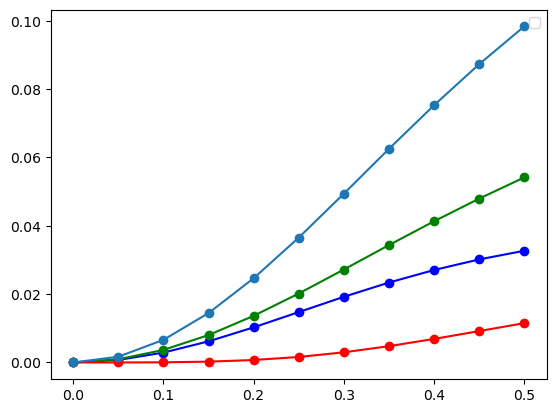

In [4]:


plt.plot(relative_strength/om_r, photon_occupation_zo, '-bo')
plt.plot(relative_strength/om_r, photon_occupation_fo, '-go')
plt.plot(relative_strength/om_r, photon_occupation_so, '-ro')
plt.plot(relative_strength/om_r, photon_occupation, '-o')

#plt.plot(relative_strength[1,:]/om_r, photon_occupation_L[1,:], 'y--')
#plt.plot(relative_strength[2,:]/om_r, photon_occupation_L[2,:], 'g--')
#plt.plot(relative_strength[3,:]/om_r, photon_occupation_L[3,:], 'r--')
#plt.plot(relative_strength[4,:]/om_r, photon_occupation_L[4,:], '-o')
#plt.xlim(0,0.65)
#plt.ylim(0,0.045)
plt.legend()
plt.show()

#for i in range(0, len(relative_strength[1,:])):
#    print(relative_strength[0,i]/om_r, photon_occupation_L[0,i],
#          relative_strength[1,i]/om_r, photon_occupation_L[1,i],
#          relative_strength[2,i]/om_r, photon_occupation_L[2,i],
#          relative_strength[3,i]/om_r, photon_occupation_L[3,i],
#          relative_strength[4,i]/om_r, photon_occupation_L[4,i])




#|c_o^1|^2

In [ ]:
# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
n_state = 0
l_ctr = 0
mol = psi4.geometry(molstr)
e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
for l in lambda_list:
    lam = np.array([0, 0, l])
    #mol = psi4.geometry(molstr)
    #e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    g_ctr = 0
    for g in gamma_list:
        om = om_r - g/2 * 1j
        cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
        g_c = np.sqrt(om/2) * l * max_tdm
        relative_strength[g_ctr, l_ctr] = np.real( np.sqrt( np.conj(g_c) * g_c ))
        CL = cqed_dict['ORIGINAL L VECTROS']
        po_l = 0.
        for i in range(0, len(CL[:,0])):
            if i%2==1:
                po_l += np.real(np.conj(CL[i,n_state]) * CL[i,n_state])
        photon_occupation_L[g_ctr, l_ctr] = po_l
        g_ctr += 1
    l_ctr += 1